In [5]:
# !pip install scikit-learn
# !pip install pickle



In [6]:
from sklearn import linear_model
import pickle

In [7]:
# model = pickle.load(open('logreg_model_3months.sav', 'rb'))

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os

from prepare_data import DataLoader
from evaluate_results import EvaluateResults

In [9]:
os.chdir('/Users/Hp/VS CODE/Stock market crash prediction')

In [16]:
import numpy as np
import pandas as pd
from datetime import timedelta

class DataLoader():
    def __init__(self, datasets_original, dataset_names):
        self.num_datasets = len(datasets_original)
        self.datasets_original = datasets_original
        self.dataset_names = dataset_names
        self.datases_revised = None
        self.drawdowns = None
        self.crashes = None
    
    def get_data_revised(self, crash_thresholds):
        datasets = []
        print(datasets_original)
        
        for d in self.datasets_original:

            data_original = pd.read_csv(d,index_col='Date')
            print('csv_ read')
            print(data_original)
#             print(data_original.head(5))

        
            data_original.index = pd.to_datetime(data_original.index, format='%Y-%m-%d')
            list(data_original.columns)
            print(data_original)
            data_norm = data_original['Close'] / data_original['Close'][-1]
            data_ch = data_original['Close'].pct_change()
            window = 10
            data_vol = data_original['Close'].pct_change().rolling(window).std()
            data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
            data.columns = ['price', 'norm', 'ch', 'vol']
            datasets.append(data)
        self.drawdowns = []
        self.crashes = []
        for df, ct in zip(datasets, crash_thresholds):
            pmin_pmax = (df['price'].diff(-1) > 0).astype(int).diff()
            pmax = pmin_pmax[pmin_pmax == 1]
            pmin = pmin_pmax[pmin_pmax == -1]
            # make sure drawdowns start with pmax, end with pmin:
            if pmin.index[0] < pmax.index[0]:
                pmin = pmin.drop(pmin.index[0])
            if pmin.index[-1] < pmax.index[-1]:
                pmax = pmax.drop(pmax.index[-1])
            D = (np.array(df['price'][pmin.index]) - np.array(df['price'][pmax.index]))/ np.array(df['price'][pmax.index])
            d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}
            df_d = pd.DataFrame(d).set_index('Date')
            df_d.index = pd.to_datetime(df_d.index, format='%Y-%m-%d')
            df_d = df_d.reindex(df.index).fillna(0)
            df_d = df_d.sort_values(by='drawdown')
            df_d['rank'] = list(range(1,df_d.shape[0]+1))
            self.drawdowns.append(df_d)
            df_d = df_d.sort_values(by='Date')
            df_c = df_d[df_d['drawdown'] < ct]
            df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
            self.crashes.append(df_c)
        self.datasets_revised = []  
        for i in range(len(datasets)):
            self.datasets_revised.append(pd.concat([datasets[i], self.drawdowns[i]], axis=1))
        return self.datasets_revised, self.crashes
    
    def get_dfs_xy(self, months):
    ### dfs_xy: dataframe for each dataset x (columns 0:-1) and  y (column -1)     
        dfs_x, dfs_y = [], []
        for df, c in zip(self.datasets_revised, self.crashes):
            df['ch'] = df['ch'] / abs(df['ch']).mean()
            df['vol'] = df['vol'] / abs(df['vol']).mean()
            xy = {}
            for date in df.index[252:-126]: # <--subtract 126 days in the end
                xy[date] = list([df['ch'][(date-timedelta(5)):date].mean()])
                xy[date].append(df['ch'][(date-timedelta(10)):(date-timedelta(5))].mean())
                xy[date].append(df['ch'][(date-timedelta(15)):(date-timedelta(10))].mean())
                xy[date].append(df['ch'][(date-timedelta(21)):(date-timedelta(15))].mean())
                xy[date].append(df['ch'][(date-timedelta(42)):(date-timedelta(21))].mean())
                xy[date].append(df['ch'][(date-timedelta(63)):(date-timedelta(42))].mean())
                xy[date].append(df['ch'][(date-timedelta(126)):(date-timedelta(63))].mean())
                xy[date].append(df['ch'][(date-timedelta(252)):(date-timedelta(126))].mean())
                xy[date].append(df['vol'][(date-timedelta(5)):date].mean())
                xy[date].append(df['vol'][(date-timedelta(10)):(date-timedelta(5))].mean())
                xy[date].append(df['vol'][(date-timedelta(15)):(date-timedelta(10))].mean())
                xy[date].append(df['vol'][(date-timedelta(21)):(date-timedelta(15))].mean())
                xy[date].append(df['vol'][(date-timedelta(42)):(date-timedelta(21))].mean())
                xy[date].append(df['vol'][(date-timedelta(63)):(date-timedelta(42))].mean())
                xy[date].append(df['vol'][(date-timedelta(126)):(date-timedelta(63))].mean())
                xy[date].append(df['vol'][(date-timedelta(252)):(date-timedelta(126))].mean())
                xy[date] = xy[date] + [max([date <= c and date + timedelta(month * 21) > c \
                          for c in c['crash_st']]) for month in months]
            df_xy = pd.DataFrame.from_dict(xy, orient='index').dropna()
            df_x = df_xy.iloc[:, :-len(months)]
            df_y = df_xy.iloc[:, -len(months):]
            dfs_x.append(df_x)
            dfs_y.append(df_y)
        return dfs_x, dfs_y
    
    def get_dfs_xy_predict(self, months):
    ### dfs_xy: dataframe for each dataset x (columns 0:-1) and  y (column -1)     
        dfs_x, dfs_y = [], []
        for df, c in zip(self.datasets_revised, self.crashes):
            df['ch'] = df['ch'] / abs(df['ch']).mean()
            df['vol'] = df['vol'] / abs(df['vol']).mean()
            xy = {}
            for date in df.index: # <--subtract 126 days in the end
                xy[date] = list([df['ch'][(date-timedelta(5)):date].mean()])
                xy[date].append(df['ch'][(date-timedelta(10)):(date-timedelta(5))].mean())
                xy[date].append(df['ch'][(date-timedelta(15)):(date-timedelta(10))].mean())
                xy[date].append(df['ch'][(date-timedelta(21)):(date-timedelta(15))].mean())
                xy[date].append(df['ch'][(date-timedelta(42)):(date-timedelta(21))].mean())
                xy[date].append(df['ch'][(date-timedelta(63)):(date-timedelta(42))].mean())
                xy[date].append(df['ch'][(date-timedelta(126)):(date-timedelta(63))].mean())
                xy[date].append(df['ch'][(date-timedelta(252)):(date-timedelta(126))].mean())
                xy[date].append(df['vol'][(date-timedelta(5)):date].mean())
                xy[date].append(df['vol'][(date-timedelta(10)):(date-timedelta(5))].mean())
                xy[date].append(df['vol'][(date-timedelta(15)):(date-timedelta(10))].mean())
                xy[date].append(df['vol'][(date-timedelta(21)):(date-timedelta(15))].mean())
                xy[date].append(df['vol'][(date-timedelta(42)):(date-timedelta(21))].mean())
                xy[date].append(df['vol'][(date-timedelta(63)):(date-timedelta(42))].mean())
                xy[date].append(df['vol'][(date-timedelta(126)):(date-timedelta(63))].mean())
                xy[date].append(df['vol'][(date-timedelta(252)):(date-timedelta(126))].mean())
                xy[date] = xy[date] + [max([date <= c and date + timedelta(month * 21) > c \
                          for c in c['crash_st']]) for month in months]
            df_xy = pd.DataFrame.from_dict(xy, orient='index').dropna()
            df_x = df_xy.iloc[:, :-len(months)]
            df_y = df_xy.iloc[:, -len(months):]
            dfs_x.append(df_x)
            dfs_y.append(df_y)
        return dfs_x, dfs_y

    def get_train_test(self, dfs_x, dfs_y, datasets, test_data):
        for i, name in enumerate(datasets):
            if name == test_data:
                index = i
        dfs_x_copy = list(dfs_x)
        dfs_y_copy = list(dfs_y)
        np_x_test = None
        np_y_test = None
        if test_data:
            df_x_test = dfs_x_copy.pop(index)
            df_y_test = dfs_y_copy.pop(index)
            np_x_test = np.array(df_x_test)
            np_y_test = np.array(df_y_test)
        np_x_train = np.concatenate(([np.array(x) for x in dfs_x_copy]))
        np_y_train = np.concatenate(([np.array(y) for y in dfs_y_copy]))
        return np_x_train, np_y_train, np_x_test, np_y_test

    def split_results(self, df_combined, dfs_xy, dataset_names, test_data, y_pred_t_bin, \
                      y_pred_tr_bin, y_train, y_test):
        df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
        dfs_predict = []
        n = 0
        for df, name in zip(df_combined, dataset_names):
            if name == test_data:
                df['y'] = y_test
                df['y_pred'] = y_pred_t_bin
                dfs_predict.append(df)
            else:
                df['y'] = y_train[n:n+df.shape[0]]
                df['y_pred'] = y_pred_tr_bin[n:n+df.shape[0]]
                dfs_predict.append(df)
                n += df.shape[0]
        return dfs_predict

In [17]:

datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344] # <-- Jacobsson
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264] # <-- Sornette
months = [1, 3, 6]              # <-- predict if crash n months ahead (use: 1, 3 or 6)
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
dfs_x, dfs_y = data.get_dfs_xy(months=months)

['^GSPC.csv', '^N225.csv', 'SSE.csv', '^HSI.csv', '^BSESN.csv', '^SSMI.csv', '^BVSP.csv']
csv_ read
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1950-01-03    16.660000    16.660000    16.660000    16.660000    16.660000   
1950-01-04    16.850000    16.850000    16.850000    16.850000    16.850000   
1950-01-05    16.930000    16.930000    16.930000    16.930000    16.930000   
1950-01-06    16.980000    16.980000    16.980000    16.980000    16.980000   
1950-01-09    17.080000    17.080000    17.080000    17.080000    17.080000   
...                 ...          ...          ...          ...          ...   
2018-09-06  2888.639893  2892.050049  2867.290039  2878.050049  2878.050049   
2018-09-07  2868.260010  2883.810059  2864.120117  2871.679932  2871.679932   
2018-09-10  2881.389893  2886.929932  2875.939941  2877.129883  2877.129883   
2018-09-11  2871.570068  2892.5

csv_ read
                    Open          High           Low         Close  \
Date                                                                 
1986-12-31   2568.300049   2568.300049   2568.300049   2568.300049   
1987-01-01           NaN           NaN           NaN           NaN   
1987-01-02   2540.100098   2540.100098   2540.100098   2540.100098   
1987-01-05   2552.399902   2552.399902   2552.399902   2552.399902   
1987-01-06   2583.899902   2583.899902   2583.899902   2583.899902   
...                  ...           ...           ...           ...   
2018-09-21  27712.349609  27965.960938  27536.269531  27953.580078   
2018-09-24  27783.849609  27783.849609  27425.009766  27499.390625   
2018-09-26  27606.810547  28031.810547  27589.369141  27816.869141   
2018-09-27  27912.509766  27928.289063  27638.539063  27715.669922   
2018-09-28  27879.060547  27927.949219  27672.830078  27788.519531   

               Adj Close        Volume  
Date                                  

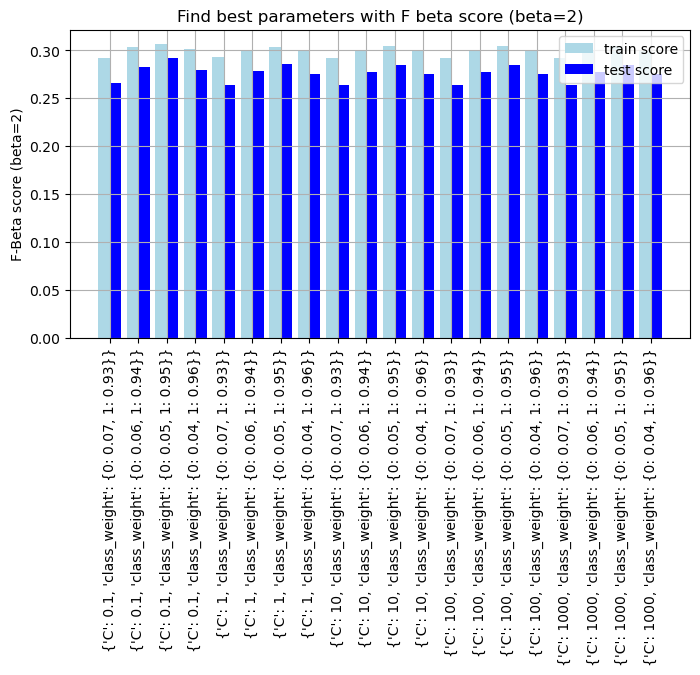

In [18]:
# -------------------- Find best parameters with grid search -------------------- #
model_name = 'Logistic Regression'
test_data = 'S&P 500'
month_prediction = 3
beta = 2

index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
x_train, y_train, _, _ = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=None)
y_train = y_train[:, index_month].astype(int)

# Find parameters with grid search:
fbeta_scorer = make_scorer(fbeta_score, beta=beta)
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.05, 1:.95}, {0:.04, 1:.96}, \
#               {0:.03, 1:.97}, {0:.025, 1:.975}, {0:.02, 1:.98}]}]   # <-- 1 month
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.07, 1:.93}, {0:.06, 1:.94}, \
                {0:.05, 1:.95}, {0:.04, 1:.96}]}]   # <-- 3 months
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.11, 1:.89}, {0:.1, 1:.9},\
#                 {0:.09, 1:.91}, {0:.08, 1:.92}]}]   # <-- 6 months

clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, scoring=fbeta_scorer, return_train_score=True) 
model = clf.fit(x_train, y_train)
labels = model.cv_results_['params']


tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']
rcParams['figure.figsize'] = 8, 4
plt.bar(x=np.arange(len(tr_score)) - 0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score)) + 0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-Beta score (beta=2)')
plt.legend()
plt.grid()
plt.show()



In [19]:
# tr_score = model.cv_results_['mean_train_score']
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [20]:
# -------------------- Train Logistic Regression -------------------- #
class_weight = {0:.06, 1:.94}
C = 1
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_val, y_val = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_val = y_train[:, index_month].astype(int), y_val[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_val_all.append(y_val)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    clf = linear_model.LogisticRegression(C=C, class_weight=class_weight)
    model = clf.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(x_val)
    y_pred_val_all.append(y_pred_val)

Train Logistic Regression - validation data: N225
Train Logistic Regression - validation data: SSE
Train Logistic Regression - validation data: HSI
Train Logistic Regression - validation data: BSESN
Train Logistic Regression - validation data: SMI
Train Logistic Regression - validation data: BVSP


In [21]:
# -------------------- Evaluate results -------------------- #
eval_ = EvaluateResults(y_train_all, y_val_all, y_pred_train_all, y_pred_val_all, model_name, test_data)
beta = 2
threshold = None
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Number of features:             ' + str(dfs_x[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Logistic Regression


Predict crash in:               3 months
Number of features:             16
Number of rows in training set: 42842


Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.04  0.04  0.04   0.04  0.04  0.04
positive pred train    0.14  0.17  0.17   0.16  0.16  0.16
precision train        0.17  0.12  0.12   0.13  0.12  0.12
recall train           0.56  0.46  0.46   0.46  0.43  0.43
accuracy_train         0.86  0.83  0.83   0.84  0.84  0.84
score_fbeta train      0.38  0.30  0.30   0.30  0.28  0.29
positive actual val    0.05  0.04  0.04   0.04  0.05  0.04
positive pred val      0.19  0.16  0.17   0.15  0.14  0.13
precision val          0.06  0.16  0.11   0.10  0.16  0.20
recall val             0.26  0.71  0.47   0.37  0.41  0.58
accuracy val           0.79  0.85  0.82   0.84  0.85  0.88
score fbeta val        0.16  0.42  0.28   0.24  0.31  0.42


Results - average over all train/val splits:
Positive train

In [22]:
# -------------------- Test model -------------------- #
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
lm = linear_model.LogisticRegression(C=C, class_weight=class_weight)
model = lm.fit(x_train, y_train)
y_pred_test_bin = model.predict(x_test).astype(int)
threshold = None
_ = eval_.test_results(y_test, y_pred_test_bin, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.15
Precision test (model/random):      0.15 / 0.04
Recall test (model/random):         0.56 / 0.15
Accuracy test (model/random):       0.85 / 0.82
Score test fbeta:                   0.36 / 0.1


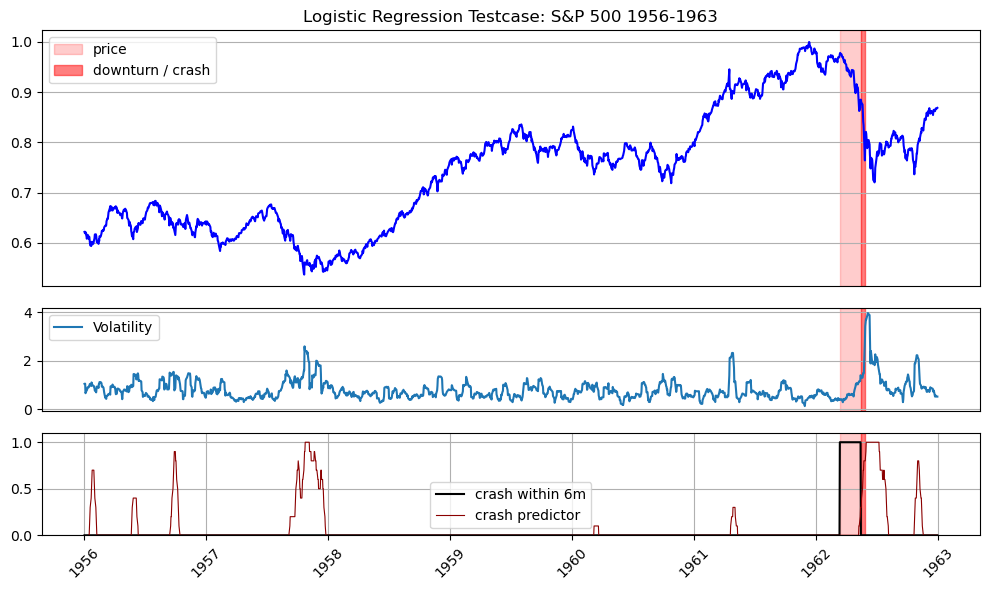

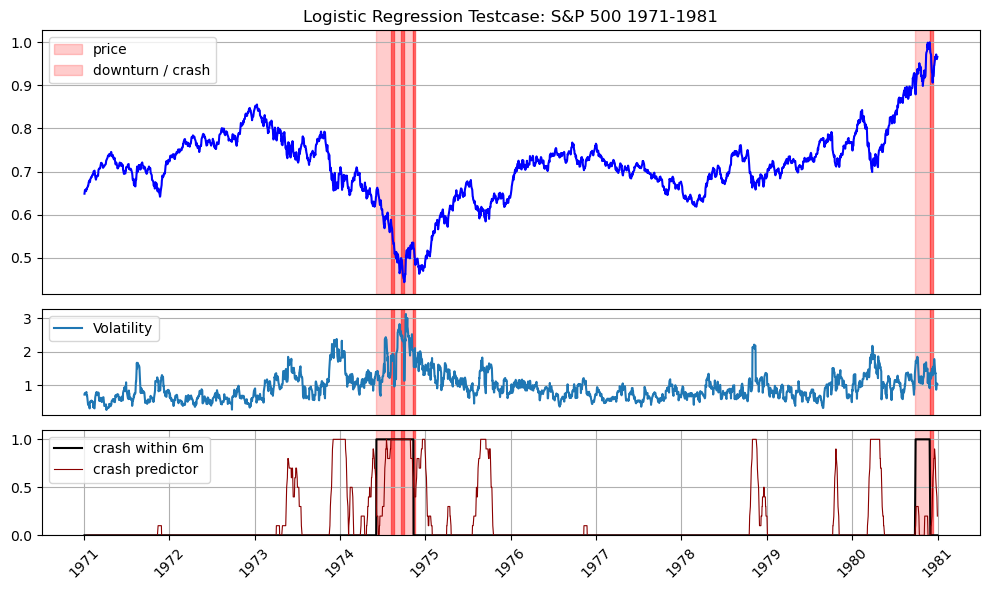

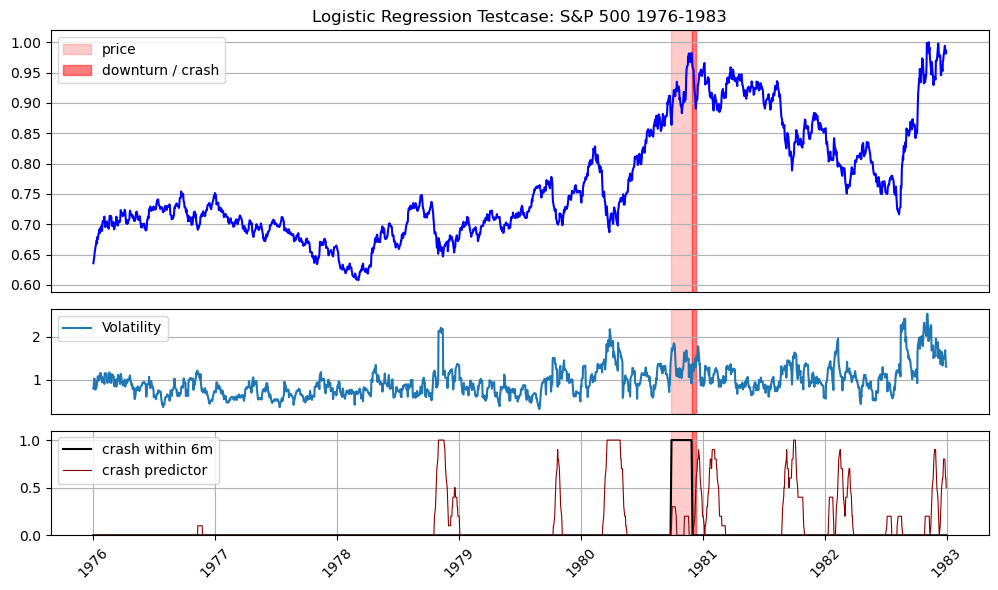

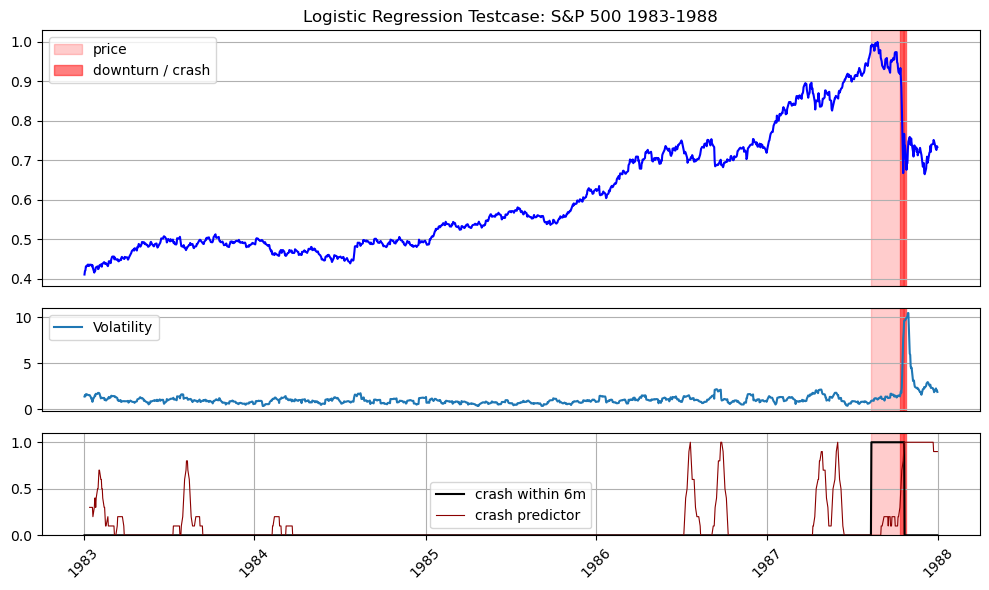

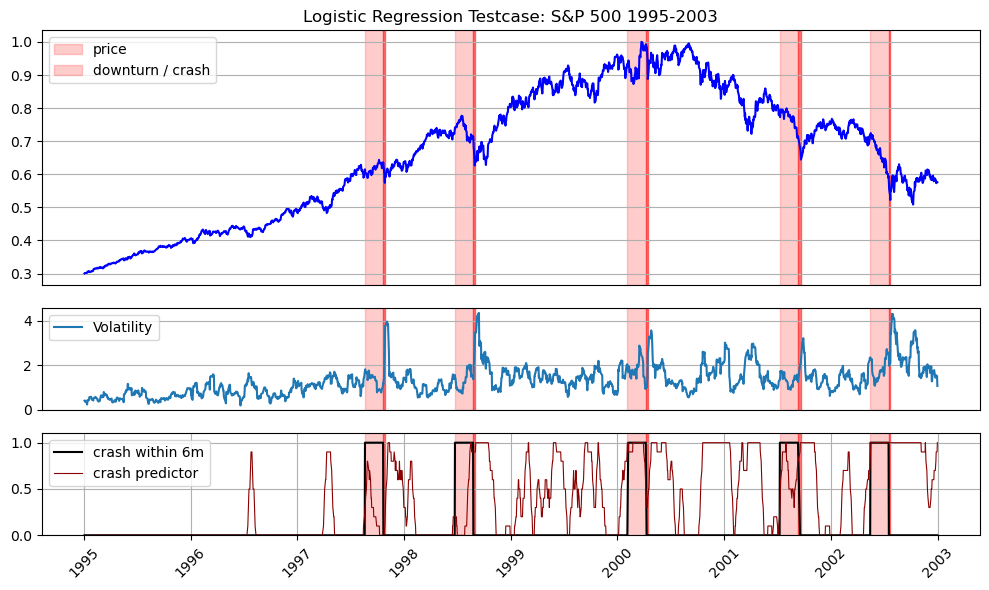

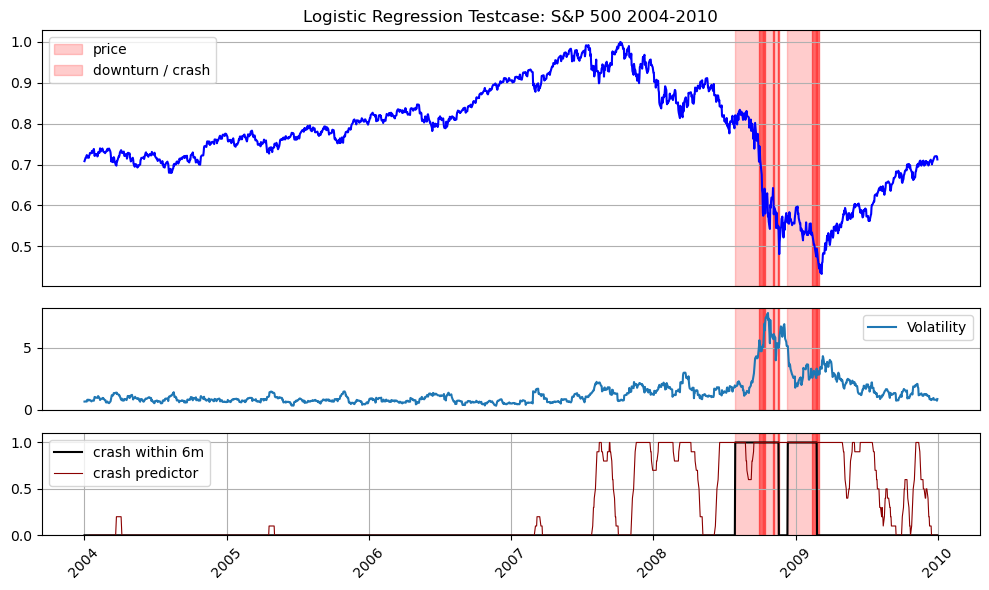

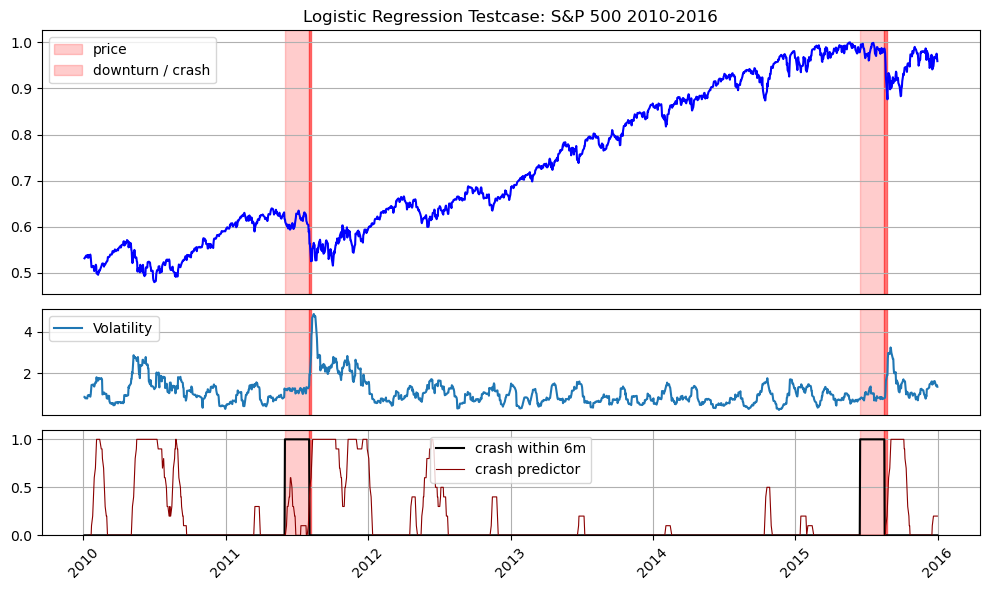

In [23]:

# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [24]:
# -------------------- Current prediction S&P 500 -------------------- #
# train on all available data:
os.chdir('/Users/Hp/VS CODE/Stock market crash prediction')
x_train, y_train, _, _ = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=None)
C = [1, 1, 1]
class_weights = [{0:.06, 1:.94}, {0:.06, 1:.94}, {0:.08, 1:.92}]
dataset_original = ['^GSPC_11-05.csv']
dataset_name = ['S&P 500']
crash_threshold = [-0.0936]
data_new = DataLoader(dataset_original, dataset_name)
dataset_revised, crashes = data_new.get_data_revised(crash_threshold)
dfs_x_new, dfs_y_new = data_new.get_dfs_xy_predict(months=months)
x_new, _, _, _ = data_new.get_train_test(dfs_x_new, dfs_y_new, dataset_name, test_data=None)

os.chdir('/Users/Hp/VS CODE/Stock market crash prediction')
for index_month in range(len(months)):
    y_train_ = y_train[:, index_month].astype(int)
    lm = linear_model.LogisticRegression(C=C[index_month], class_weight=class_weights[index_month])
    model = lm.fit(x_train, y_train_)
    filename = 'logreg_model_{}months.sav'.format(months[index_month])
    pickle.dump(model, open(filename, 'wb'))
    y_pred_new_bin = model.predict(x_new).astype(int)
    current_pred = np.dot(np.linspace(0,1,21) / sum(np.linspace(0,1,21)), y_pred_new_bin[-21:])
    print(str(model_name) + ' prediction of a crash within ' + str(months[index_month]) \
          + ' months: ' + str(np.round(current_pred, 2)))

['^GSPC.csv', '^N225.csv', 'SSE.csv', '^HSI.csv', '^BSESN.csv', '^SSMI.csv', '^BVSP.csv']
csv_ read
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-11-05  1765.670044  1767.030029  1755.760010  1762.969971  1762.969971   
2013-11-06  1765.000000  1773.739990  1764.400024  1770.489990  1770.489990   
2013-11-07  1770.739990  1774.540039  1746.199951  1747.150024  1747.150024   
2013-11-08  1748.369995  1770.780029  1747.630005  1770.609985  1770.609985   
2013-11-11  1769.959961  1773.439941  1767.849976  1771.890015  1771.890015   
...                 ...          ...          ...          ...          ...   
2018-10-29  2682.649902  2706.850098  2603.540039  2641.250000  2641.250000   
2018-10-30  2640.679932  2685.429932  2635.340088  2682.629883  2682.629883   
2018-10-31  2705.600098  2736.689941  2705.600098  2711.739990  2711.739990   
2018-11-01  2717.580078  2741.6